# Welcome to Executor!
Jason's naive model for doing high frequency trading <br>
Use a Qnet to determine whether it's a good time to sell or buy or stay <br>
Then a helper model to decide whether to execute the command from Qnet or just stay if considering the transaction fee <br>

Thanks for this useful link:https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial <br>
So far, Reinforcement learning algorithms are not well GPU optimized since it's hard to do parallization in updating stages + reward. Thus, the DQN part is CPU only :) <br>
Thanks to this useful link : https://adventuresinmachinelearning.com/reinforcement-learning-tensorflow/ <br>
Here we didn't consider the Volume





# What's new:
Add tick dataset :) <br>
Add transaction fee <br>
The model needs to learn how to avoid the cost from transaction fee, which means it should avoid buying too many times <br>
You can add a supplimentary model for Qnet (No consideration for transaction fee), and let it consider the transaction cost <br>
A trail model will be: Use a LSTM and input action and output the same way with loss = loss-transaction fee <br>
The model simply decide whether to execute this order or just stay. Buy and sell are determined by Qnet <br>

In [188]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import tensorflow as tf
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt
color_array = list(mcolors.CSS4_COLORS.keys())
root_path = 'Data/Stocks/'
#root_path = "/kaggle/input/price-volume-data-for-all-us-stocks-etfs/ETFs/"

## Here we got 2 sets of data: Google stock price daily and Google stock price in 5 days (sample rate=1min)

df = pd.read_csv(root_path + "googl.us.txt")
# This time Let's do apple :)
#df_hf = pd.read_csv("Data/High_frequency_data/GOOG_stock_1minute_sample/GOOG_sample.txt",names=["DateTime", "Open", "High", "Low", "Close","Volume"])





In [189]:
# For tick data
df_hf = pd.read_csv("Data/High_frequency_data/GOOG_stock_tick_sample/GOOG_2020-07-01.txt",names=["DateTime", "Close","Volume"],index_col=3)
df_hf.set_index(np.arange(0,df_hf.shape[0],1),inplace=True)



In [190]:
df_hf.head()

,DateTime,Close,Volume
0,2020-07-01 04:16:07:301,1413.61,1
1,2020-07-01 04:21:17:549,1414.01,50
2,2020-07-01 05:10:42:852,1413.94,1
3,2020-07-01 05:16:15:159,1413.94,17
4,2020-07-01 05:16:15:159,1413.94,50


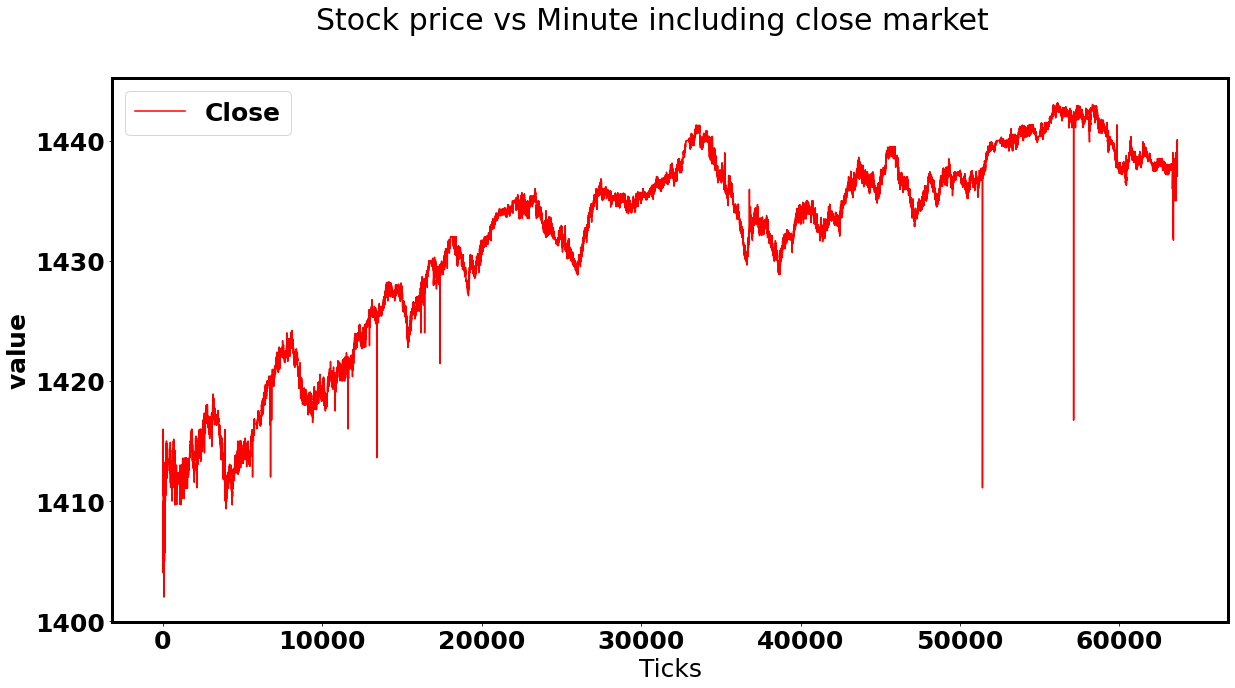

In [191]:
import matplotlib
from matplotlib.pylab import rc
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)

#plt.plot(df_hf["Open"],"k",label= "Open")
plt.plot(df_hf["Close"],"r",label= "Close")

plt.xlabel("Ticks")
plt.ylabel(r"${\rm value}$")
plt.suptitle("Stock price vs Minute including close market")
plt.legend()

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20,10)

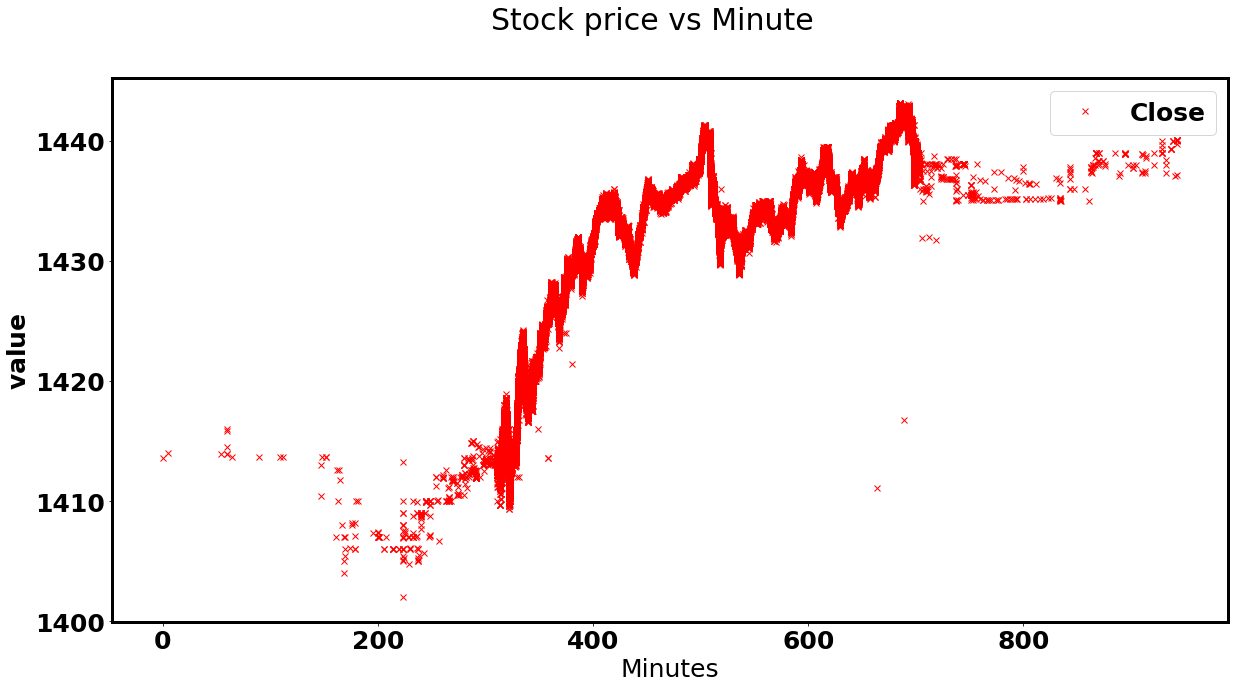

In [192]:

df_hf["DateTime"] = pd.to_datetime(df_hf["DateTime"], format="%Y-%m-%d %H:%M:%S:%f")
delta_min = (df_hf["DateTime"]-df_hf["DateTime"][0]).dt.total_seconds()//60


import matplotlib
from matplotlib.pylab import rc
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)

#plt.plot(delta_min,df_hf["Open"],"kx",label= "Open")
plt.plot(delta_min,df_hf["Close"],"rx",label= "Close")

plt.xlabel("Minutes")
plt.ylabel(r"${\rm value}$")
plt.suptitle("Stock price vs Minute")
plt.legend()

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20,10)

In [193]:
# This time Try DQN on df and df_hf
# History_t set to be 90, you can change that
from chainer.backends import cuda

# GPU?
"""
with cupy.cuda.Device(1):
    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    
"""
    
class Environment1:
    # def __init__(self, data, history_t=90):
    def __init__(self, data, history_t=100):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + self.history # obs
    
    def step(self, act):
        reward = 0
        
        # act = 0: stay, 1: buy, 2: sell
        if act == 1:
            self.positions.append(self.data.iloc[self.t, :]['Close'])
        elif act == 2: # sell: We sell all previous buys
            if len(self.positions) == 0:
                reward = -1
            else:
                profits = 0
                for p in self.positions:
                    # Here we add transaction fee:
                    #profits += (self.data.iloc[self.t, :]['Close'] - p*(1+ratio))
                    # For google 
                    ratio = 0.005
                    profits += (self.data.iloc[self.t, :]['Close'] - p)
                reward += profits
                self.profits += profits
                self.positions = []
        
        # set next time
        self.t += 1
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['Close'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['Close'] - self.data.iloc[(self.t-1), :]['Close'])
        
        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        
        return [self.position_value] + self.history, reward, self.done



In [194]:
# Set up environment:


data_hf = df_hf.set_index('DateTime')
env_hf = Environment1(df_hf)

In [195]:
# Optional: reduce sample size:

df_hf = df_hf.iloc[int(df_hf.shape[0]*0.6):int(df_hf.shape[0]*0.7),:]

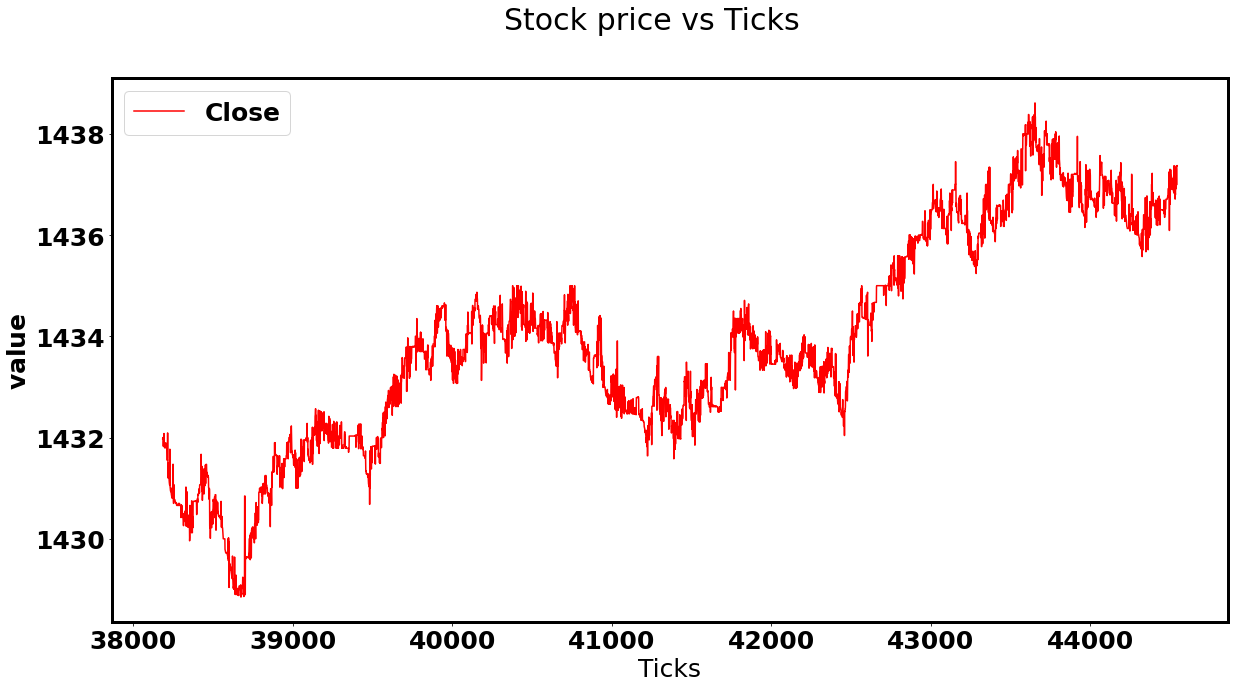

In [196]:
# Optional: reduce sample size:



import matplotlib
from matplotlib.pylab import rc
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)

plt.plot(df_hf["Close"],"r",label= "Close")

plt.xlabel("Ticks")
plt.ylabel(r"${\rm value}$")
plt.suptitle("Stock price vs Ticks")
plt.legend()

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20,10)

In [197]:
delta_split = int(df_hf.shape[0]*0.7)
train_hf = df_hf[:delta_split]
test_hf = df_hf[delta_split:]
print("Training date length hf",len(train_hf),"testing date length hf", len(test_hf))

Training date length hf 4454 testing date length hf 1910


In [198]:
import chainer
import chainer.functions as F
import chainer.links as L
import copy
import time



def train_dqn(env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()

    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    # GPU Option
    #Q.to_gpu()
    
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)
    
    # Hyper-parameters
    epoch_num = 25
    step_max = len(env.data)-1
    memory_size = 400
    batch_size = 40
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    show_log_freq = 3


    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    start = time.time()
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0

        while not done and step < step_max:

            # select act
            pact = np.random.randint(3)
            if np.random.rand() > epsilon:
                pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                pact = np.argmax(pact.data)

            # act
            obs, reward, done = env.step(pact)

            # add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # train or update q
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
            start = time.time()
            
    return Q, total_losses, total_rewards




In [199]:
# Dueling Double DQN

def train_dddqn(env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, hidden_size//2),
                fc4 = L.Linear(hidden_size, hidden_size//2),
                state_value = L.Linear(hidden_size//2, 1),
                advantage_value = L.Linear(hidden_size//2, output_size)
            )
            self.input_size = input_size
            self.hidden_size = hidden_size
            self.output_size = output_size

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            hs = F.relu(self.fc3(h))
            ha = F.relu(self.fc4(h))
            state_value = self.state_value(hs)
            advantage_value = self.advantage_value(ha)
            advantage_mean = (F.sum(advantage_value, axis=1)/float(self.output_size)).reshape(-1, 1)
            q_value = F.concat([state_value for _ in range(self.output_size)], axis=1) + (advantage_value - F.concat([advantage_mean for _ in range(self.output_size)], axis=1))
            return q_value

        def reset(self):
            self.zerograds()
    """ >>> """

    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    epoch_num = 50
    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 50
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    show_log_freq = 5

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    start = time.time()
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0

        while not done and step < step_max:

            # select act
            pact = np.random.randint(3)
            if np.random.rand() > epsilon:
                pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                pact = np.argmax(pact.data)

            # act
            obs, reward, done = env.step(pact)

            # add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # train or update q
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                        """ <<< DQN -> Double DQN
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        === """
                        indices = np.argmax(q.data, axis=1)
                        maxqs = Q_ast(b_obs).data
                        """ >>> """
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            """ <<< DQN -> Double DQN
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                            === """
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxqs[j, indices[j]]*(not b_done[j])
                            """ >>> """
                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
            start = time.time()
            
    return Q, total_losses, total_rewards

In [ ]:
# Train on google_per_minute:
# Epoch, epsilon (Randomness in your strategy), steps,log[reward],log[loss], elapsed time


# Q, total_losses, total_rewards = train_dddqn(Environment1(train_hf))

Q, total_losses, total_rewards = train_dqn(Environment1(train_hf))

3	0.0999999999999992	13359	101.33333333333333	183.3521026026768	141.14756751060486
6	0.0999999999999992	26718	251.0	328.38625811606954	143.33566284179688


In [ ]:

plt.subplot(1,2,1)
plt.plot(total_losses,"r",label="loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(total_rewards,"b",label="Reward")
plt.xlabel("Epoch")
plt.ylabel("Reward")

plt.legend()



fig = matplotlib.pyplot.gcf()

fig.set_size_inches(22,9)
plt.legend()
plt.show()

In [ ]:
# test
test_env = Environment1(test_hf)


# test
pobs = test_env.reset()
test_acts = []
test_rewards = []

for _ in range(len(test_env.data) - 1):
    pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
    pact = np.argmax(pact.data)
    test_acts.append(pact)

    obs, reward, done = test_env.step(pact)
    test_rewards.append(reward)

    pobs = obs

test_profits = test_env.profits

print("Test revenue =%.4f in %d steps start price %.4f"%(test_profits,test_env.data.shape[0],test_env.data.iloc[0,1]))



In [ ]:
# Our actions in testing set:
# Here 0 means stay, 1 means buy 2 means sell
plt.hist(test_acts,label = "0 stay 1 buy 2 sell")

fig = matplotlib.pyplot.gcf()

fig.set_size_inches(22,10)
plt.legend()
plt.show()



In [ ]:
delta_sec = (test_env.data["DateTime"]-test_env.data.iloc[0,0]).dt.total_seconds()

plt.subplot(1,1,1)
y = test_env.data["Close"].values[:-1]

test_acts = np.array(test_acts)

m0 = test_acts==0
m1 = test_acts==1
m2 = test_acts==2
plt.plot(np.arange(0,len(y),1),y,label = "Close price")
plt.plot(np.arange(0,len(y),1)[m0],y[m0],"ko",label = "Stay")
plt.plot(np.arange(0,len(y),1)[m1],y[m1],"ro",label = "Buy")
plt.plot(np.arange(0,len(y),1)[m2],y[m2],"go",label = "Sell")

plt.xlabel("Minutes ")
plt.ylabel("Price")
plt.suptitle("Total revenue %.4f"%test_profits)



fig = matplotlib.pyplot.gcf()

fig.set_size_inches(22,10)
plt.legend()
plt.show()

# Add helper model to decide whether execute this order from DQN or not
Since we didn't consider the transaction fee <br>
Ideas: (Traders don't do the transaction without high odds of making money )
1. Use your time series model to predict the absolute change in price. If it's bigger than a threthold, do the trading.
2. Naive one, just increase and decrese price trend. Define a window let's say size=50. In the previous 50 windows, if there is a clear trend of decreasing, just stay and do buying until this trend disappear (Tell by price). Vice versa
3. Follow up for second point. Use your time series model to predict the future 25 values, if the local it's a minimum or within % minimum and the command is to buy, just do it. Vice versa. You can play around with the threshold. I would recommend start with GRU and replace it with Transformer after the baseline is working.

In [ ]:
def profit_calculator(data,actions):
    ans = 0
    # For Google it's 0.5% transaction fee
    ratio = 0.005
    history = []
    
    for i in range(len(data)):
        if actions[i]==0:
            pass
        elif actions[i]==1:
            history.append(data[i])
        else:
            ans += len(history)*data[i]-np.sum(history)*(1+ratio)
            history = []
    return ans
            
        

print(profit_calculator(y,test_acts))     

In [ ]:
N_tot = df_hf.shape[0]
N_test = test_hf.shape[0]
N_train = N_tot-N_test
price = df_hf["Close"]
print(N_tot,N_train,N_test)

In [ ]:
# Hyper-parameters:

input_seq_length = 720
window_size = 8
threshold = 5

# Since there is a sliding window :) 
N_test = N_test-window_size//2


# prepare dataset:
X = []
y = []
y_windows = []

for i in range(N_test):
    y.append(price[N_train+i:N_train+window_size//2+i])
    X.append(price[N_train-input_seq_length+i:N_train+i])
    
X = np.array(X)
y = np.array(y)
X = np.atleast_3d(X)
print(X.shape,y.shape)


In [ ]:
# Do the training: Use GRU to reduce training time:

# For this part I only have one day data since it'a hard to find Tick data, please replace this training set with previous 
# day dataset :) 

import tensorflow as tf

n_epoch=100
n_cell = 100
batch_size= 32


import tensorflow as tf
# design network: A toy LSTM model with 50 units
# Optional: Add Gaussian noise layer:
# ,tf.keras.layers.GaussianNoise(stddev=np.nanmean(y)*0.0001
model = tf.keras.Sequential([
  tf.keras.layers.GRU(n_cell,input_shape=(X.shape[1],1)),  # must declare input shape
  tf.keras.layers.Dense(window_size//2)
])

model.compile(loss='mae', optimizer='adam')
model.summary()


# fitting+save model

checkpoint_path = "LSTM/cp.ckpt"
#checkpoint_dir = os.path.dirname(checkpoint_path)

callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# history = model.fit(X, y, epochs=n_epoch, batch_size=batch_size,callbacks=[callback], verbose=1, shuffle=False)


## load model
#model.load_weights(checkpoint_path)








# GRU- to be continue :) 

# Idea 2: Naive one :)
Since there is a lot of buy, we need to reduce them. Sell them with caution only if the profit is positive after deducting the transaction fee.



In [ ]:
import copy
window_size = 50
threthold = 65
threthold_p = 0.2

def helper(data,actions):
    ans = 0
    
    mean_d = np.nanmean(data)
    actions_modified = copy.copy(actions)
    
    # For Google it's 0.5% transaction fee
    ratio = 0.005
    history = []
    
    for i in range(len(data)):
        if actions[i]==0:
            pass
        elif actions[i]==1:
            temp = actions[max(0,i-window_size//2):i]
            temp = list(temp)
            #print(temp)
            if temp.count(1)>threthold/100*len(temp):
                # buy
                history.append(data[i])
            else:
                # stay
                actions_modified[i]=0
                
        else:
            # p = len(history)*data[i]-np.sum(history)*(1+ratio)
            p = len(history)*data[i]-np.sum(history)-len(history)*0.05
            print(p)
            if p>mean_d*threthold_p/100:
                # sell:
                
                ans += p 
                history = []
            else:
                # stay
                actions_modified[i]=0
            
    return ans,actions_modified

profit,test_acts_mod = helper(data=test_env.data["Close"].values[:-1],actions=test_acts)
print(profit)

In [ ]:
list(test_acts).count(1)